Import dependencies and data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from utils import *
from sklearn.metrics import mean_squared_error

def load_simulation_data(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Create a dictionary to store the dataframes
    sim_dataframes = {}

    # Loop through the files and read them into dataframes
    for file in files:
        file_path = os.path.join(folder_path, file)
        df_name = file.split('.')[0]
        sim_dataframes[df_name] = pd.read_csv(file_path, skiprows=1)

    return sim_dataframes

# Load the simulation data
vert_sim_dataframes = load_simulation_data("ntrt_data")
dir_sim_dataframes  = load_simulation_data("dir_sweep_1")

# Display the names of the dataframes
print(vert_sim_dataframes.keys())
print(dir_sim_dataframes.keys())

dict_keys(['40comp_highdamp', '30comp_highdamp', '20comp_highdamp', '46comp_highdamp'])
dict_keys(['11182024_101014', '11182024_101001', '11182024_101007', '11182024_101020', '11182024_101027'])


Extract position of CoM from data

In [3]:
def create_avg_pos_dataframes(sim_dataframes):
    avg_pos_dataframes = {}
    for name, df in sim_dataframes.items():
        avg_pos_dataframes[name] = extract_position_data(df)
    return avg_pos_dataframes

# Create a new dictionary to store the position dataframes
vert_avg_pos_dataframes = create_avg_pos_dataframes(vert_sim_dataframes)
dir_avg_pos_dataframes  = create_avg_pos_dataframes(dir_sim_dataframes)

vert_avg_sim = vert_avg_pos_dataframes['46comp_highdamp']
dir_avg_sim  = dir_avg_pos_dataframes['11182024_101020']

# For the direction jump we need to combine x and z directions (requires zeroing the x direction)
x_zeroing_val       = 0.1
dir_avg_sim['dist'] = np.sqrt((dir_avg_sim['avg_x'] + x_zeroing_val)**2 + dir_avg_sim['avg_z']**2)   


Plot trajectories

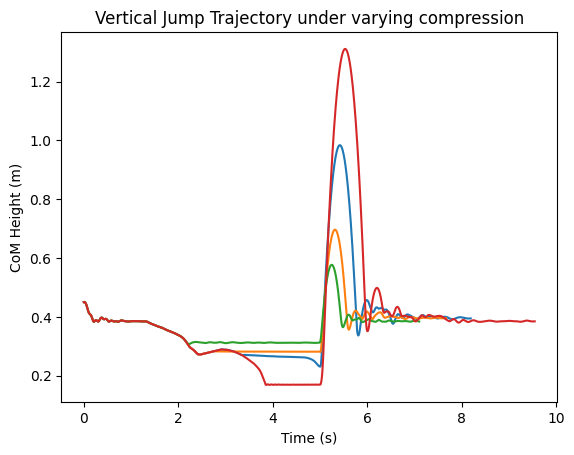

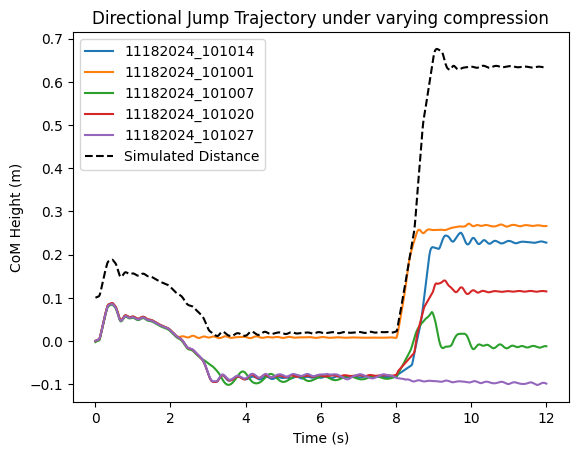

0.1689308333333333

In [4]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Loop through the sims and plot the averaged y values
for name, df in vert_avg_pos_dataframes.items():
    time = vert_sim_dataframes[name]['time']
    ax.plot(time, df['avg_y'], label=name)

# Set the labels and title
ax.set_xlabel('Time (s)')
ax.set_ylabel('CoM Height (m)')
ax.set_title('Vertical Jump Trajectory under varying compression')

# Show the plot
plt.show()

# Create a new figure and axis
fig, ax = plt.subplots()

# Loop through the sims and plot the averaged y values
for name, df in dir_avg_pos_dataframes.items():
    time = dir_sim_dataframes[name]['time']
    ax.plot(time, df['avg_x'], label=name)

# Plot the distance from dir_avg_sim
ax.plot(dir_sim_dataframes['11182024_101020']['time'], dir_avg_sim['dist'], label='Simulated Distance', linestyle='--', color='black')

# Set the labels and title
ax.set_xlabel('Time (s)')
ax.set_ylabel('CoM Height (m)')
ax.set_title('Directional Jump Trajectory under varying compression')
# Add legend to the plot
ax.legend()

# Show the plot
plt.show()

np.min(vert_avg_pos_dataframes['46comp_highdamp']['avg_y'])

Create trajectories from measured data

In [5]:
# Load the sheets "46comp" and "50dir" from the Excel file into DataFrames
file_path = "stb_vert_trajectories.xlsx"
df_vert = pd.read_excel(file_path, sheet_name="46comp")
df_dir  = pd.read_excel(file_path, sheet_name="50dir")

# Ensure trajectories all start at the same point
for col in df_vert.columns:
    if col.startswith('x'):
        df_vert[col] -= df_vert[col].iloc[0]

for col in df_dir.columns:
    if col.startswith('x'):
        df_dir[col] -= df_dir[col].iloc[0]

vert_avg = create_averaged_trajectory(df_vert)
dir_avg  = create_averaged_trajectory(df_dir)

vert_avg.head()

,t_common,y_avg,x_avg
0,0.000000,0.008655,0.000000
1,0.010938,0.017769,0.003182
2,0.021875,0.019053,0.005115
3,0.032813,0.027932,0.010262
4,0.043750,0.054573,0.012881


Create plots

211
Mean Square Error between the averaged measured trajectory and the simulated trajectory (Y): 0.002900823218949428
0.0015663581715095805
Mean Square Error between the averaged measured trajectory and the simulated trajectory (X): 0.00023189312406973297


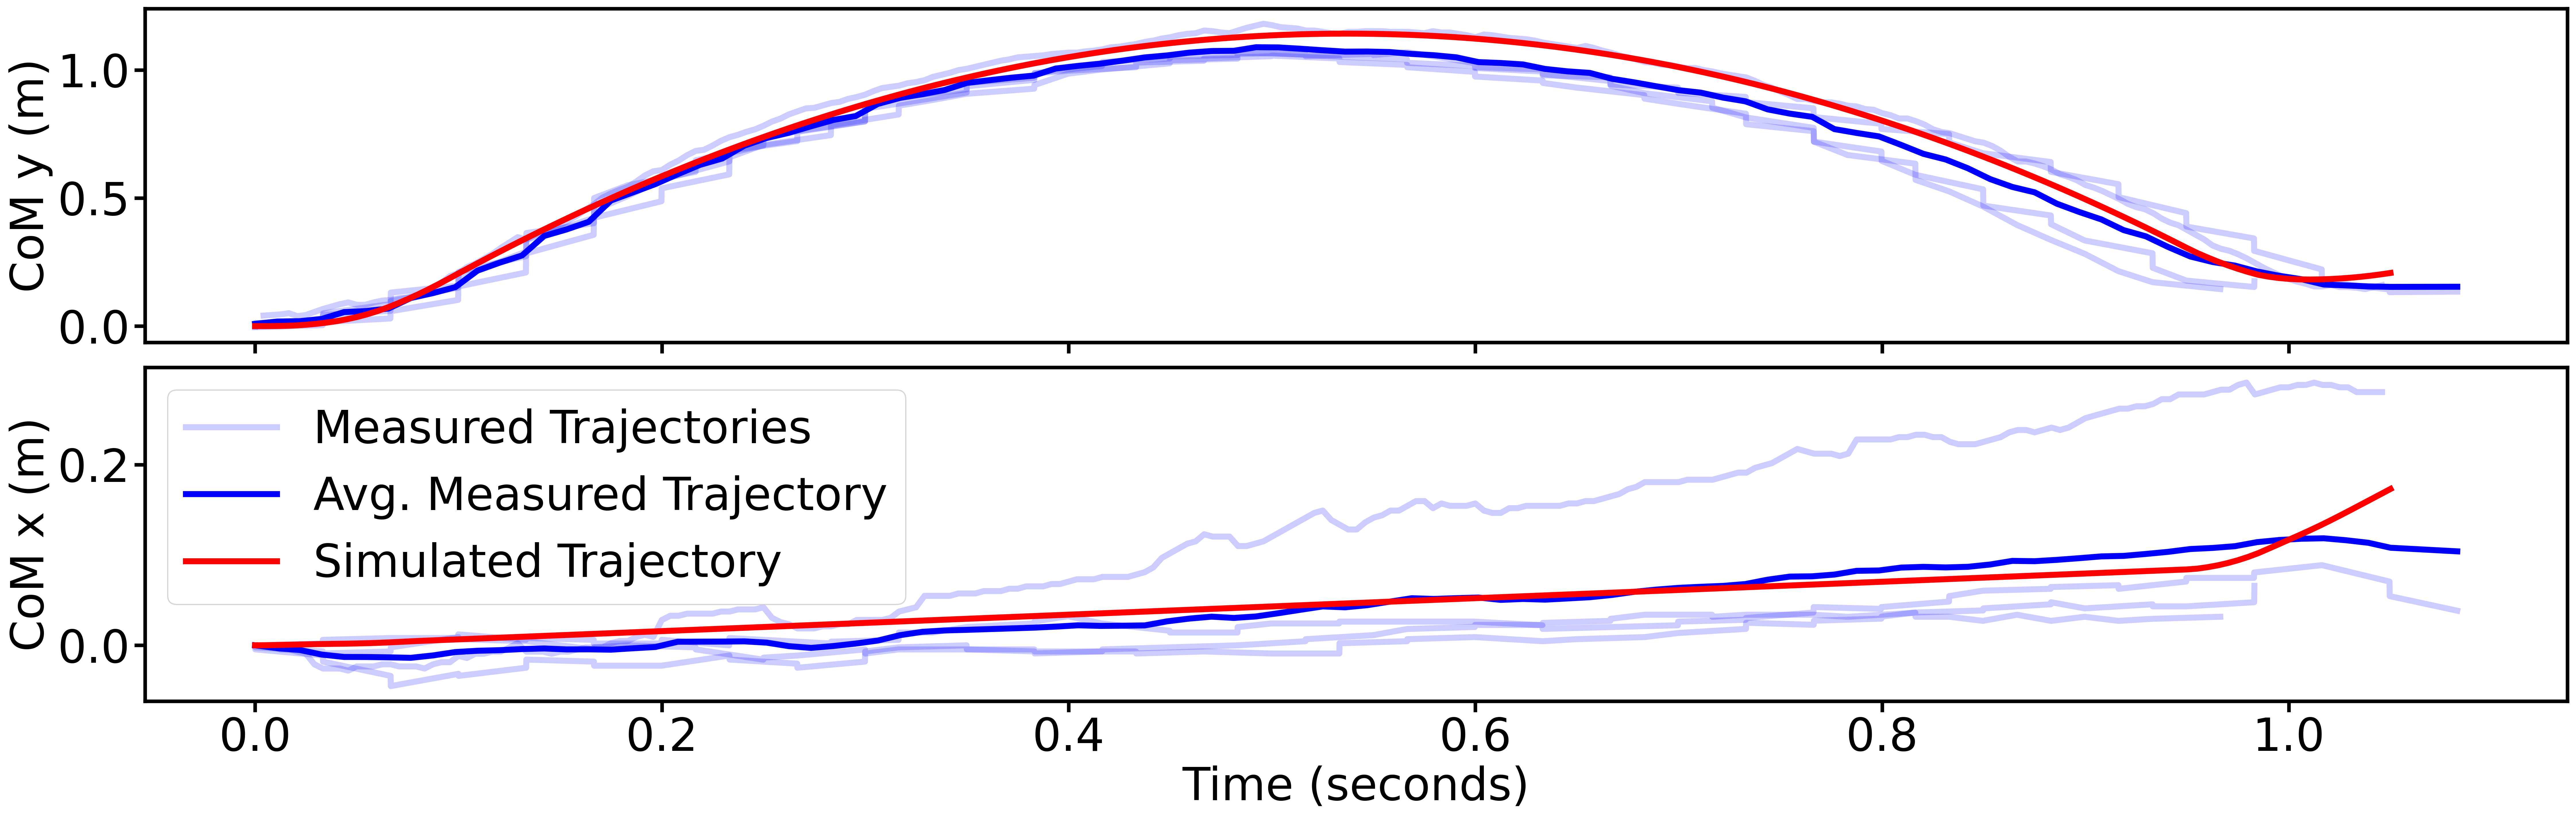

131
Mean Square Error between the averaged measured trajectory and the simulated trajectory (Y): 0.006400100509894052
0.007893775664385474
Mean Square Error between the averaged measured trajectory and the simulated trajectory (X): 0.009387450818876897


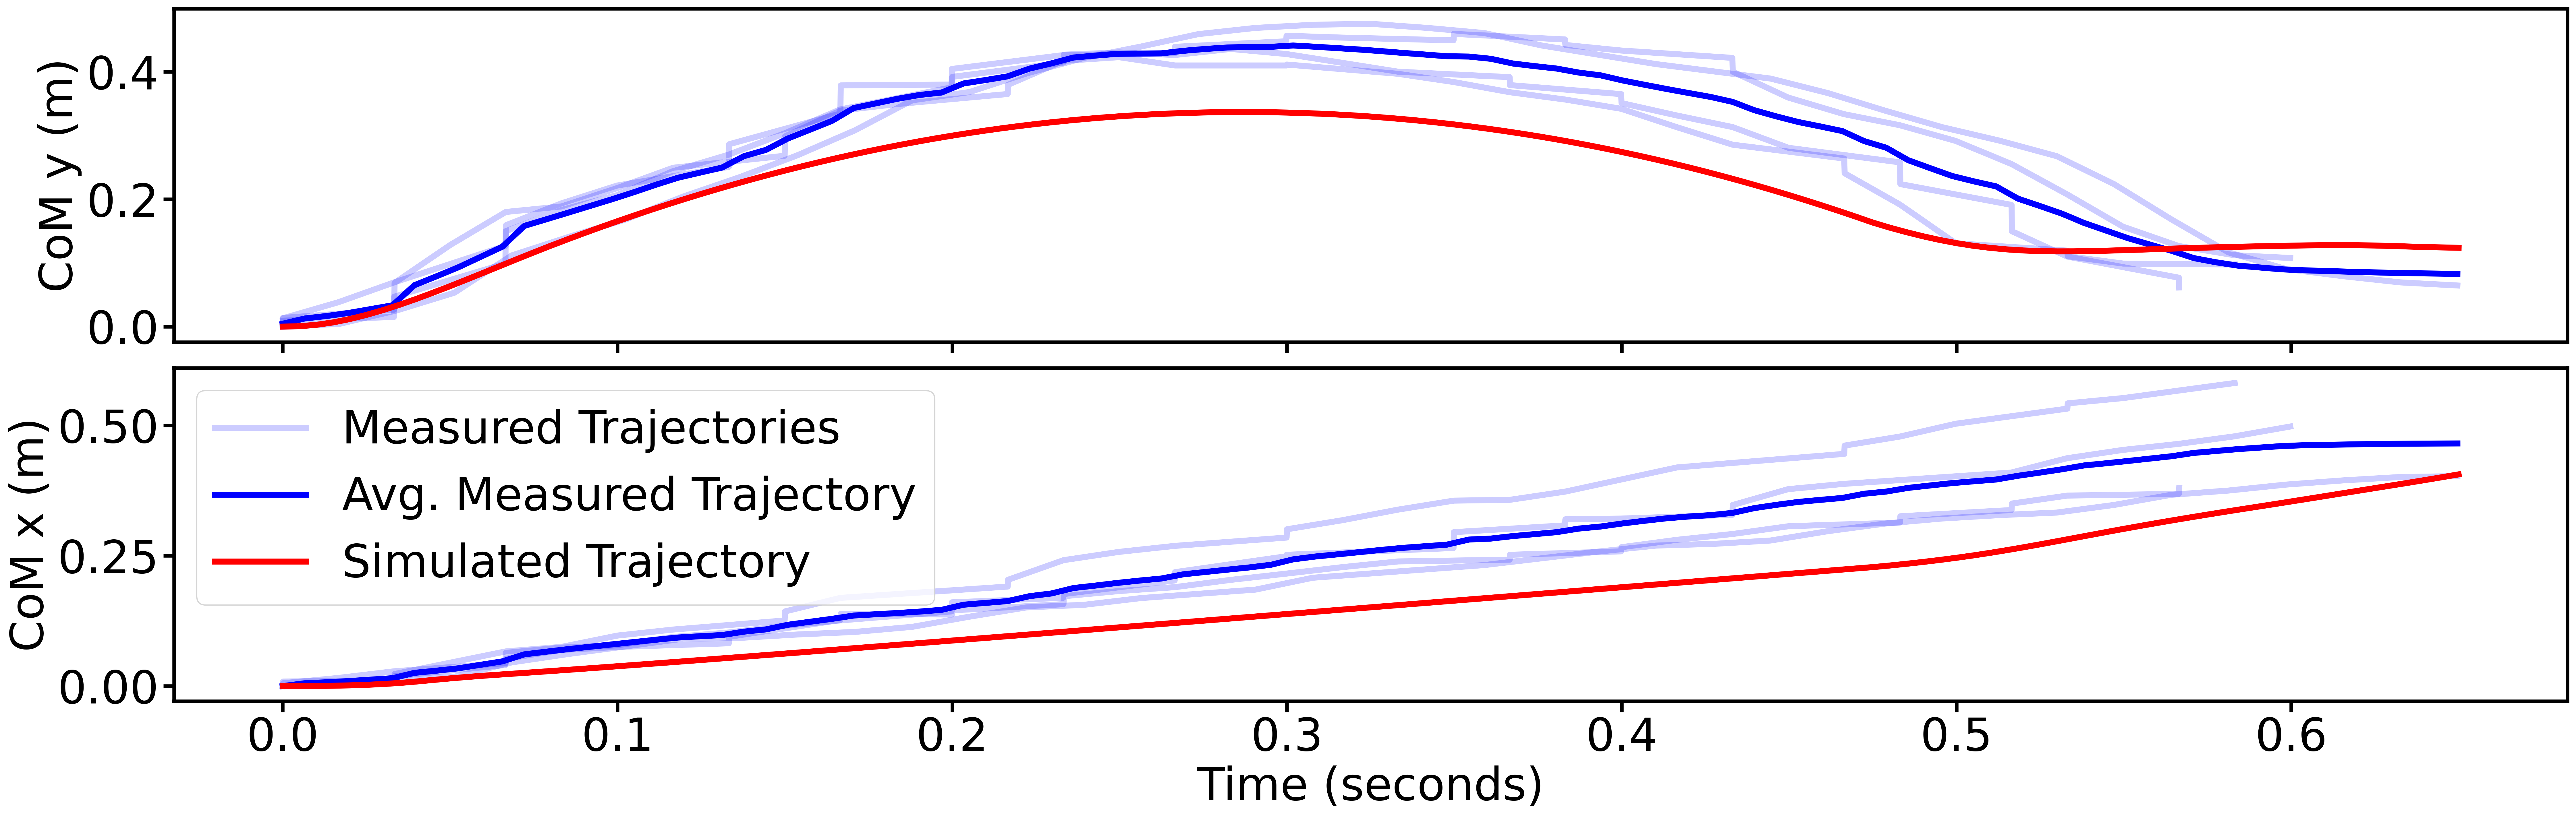

In [7]:
def plot_measured_vs_simulated_trajectory(measured_dataframe, averaged_measured, ntrt_dataframes, avg_pos_dataframes, t_shift=5.0, t_duration=1.05, title=''):
    font_size = 38
    line_weight = 5
    box_line_weight = 3  # Added line weight for the plot box

    # Create subplots with shared x-axis
    fig, axs = plt.subplots(2, 1, figsize=(30, 10), sharex=True, dpi=300)

    # Plot y vs t
    for i in range(1, 5):
        axs[0].plot(measured_dataframe[f't{i}'], measured_dataframe[f'y{i}'], color='blue', alpha=0.2, label=f'Measured Trajectories' if i == 1 else "", linewidth=line_weight)
    axs[0].plot(averaged_measured['t_common'], averaged_measured['y_avg'], color='blue', alpha=1.0, label='Averaged Measured Trajectory', linewidth=line_weight)

    t_shifted = ntrt_dataframes['time'] - t_shift
    mask = (t_shifted >= 0) & (t_shifted <= t_duration)
    y_shift = -avg_pos_dataframes['avg_y'][mask].iloc[0]
    y_shifted = avg_pos_dataframes['avg_y'][mask] + y_shift
    axs[0].plot(t_shifted[mask], y_shifted, color='red', label=f'Simulated Trajectory', linewidth=line_weight)

    axs[0].set_ylabel('CoM y (m)', fontsize=font_size)
    axs[0].tick_params(axis='both', which='major', labelsize=font_size)

    y_interp = np.interp(t_shifted[mask], averaged_measured['t_common'], averaged_measured['y_avg'])
    print(len(y_interp))
    mse_y = mean_squared_error(y_interp, y_shifted.values)
    print(f"Mean Square Error between the averaged measured trajectory and the simulated trajectory (Y): {mse_y}")

    # Plot x vs t
    for i in range(1, 5):
        axs[1].plot(measured_dataframe[f't{i}'], -measured_dataframe[f'x{i}'], color='blue', alpha=0.2, label=f'Measured Trajectories' if i == 1 else "", linewidth=line_weight)
    axs[1].plot(averaged_measured['t_common'], -averaged_measured['x_avg'], color='blue', alpha=1.0, label='Avg. Measured Trajectory', linewidth=line_weight)

    x_shifted = avg_pos_dataframes['avg_x'][mask]
    x_shifted -= x_shifted.iloc[0]
    axs[1].plot(t_shifted[mask], -x_shifted, color='red', label=f'Simulated Trajectory', linewidth=line_weight)

    axs[1].set_xlabel('Time (seconds)', fontsize=font_size)
    axs[1].set_ylabel('CoM x (m)', fontsize=font_size)
    axs[1].legend(fontsize=font_size)
    axs[1].tick_params(axis='both', which='major', labelsize=font_size)

    x_interp = np.interp(t_shifted[mask], averaged_measured['t_common'], averaged_measured['x_avg'])
    mse_x = mean_squared_error(x_interp, x_shifted.values)
    print(np.average([mse_x, mse_y]))
    print(f"Mean Square Error between the averaged measured trajectory and the simulated trajectory (X): {mse_x}")

    # Increase the line width of the plot box
    for spine in axs[0].spines.values():
        spine.set_linewidth(box_line_weight)
    for spine in axs[1].spines.values():
        spine.set_linewidth(box_line_weight)

    # Set the line width of the ticks
    axs[0].tick_params(width=box_line_weight, length=3*box_line_weight)
    axs[1].tick_params(width=box_line_weight, length=3*box_line_weight)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    plt.savefig(title + '.svg', format='svg')

    plt.show()
    
# Call the function with the appropriate arguments
plot_measured_vs_simulated_trajectory(df_vert, vert_avg, vert_sim_dataframes['46comp_highdamp'], vert_avg_sim, title='vert_compare')
dir_avg_sim['avg_x'] = -dir_avg_sim['dist']
plot_measured_vs_simulated_trajectory(df_dir, dir_avg, dir_sim_dataframes['11182024_101007'], dir_avg_sim, t_shift=8.0, t_duration=0.653, title='dir_compare')
